# Content Writing Agent
The system defines a state-driven content generation workflow that integrates research, keyword analysis, content writing, and refinement. It begins with topic analysis using Google Trends to identify rising and related keywords, followed by reference gathering from Wikipedia to avoid knowledge cutoff. Based on the user’s goal (marketing, social, technical, or education), content is generated through specialized writer nodes. The output is then validated against trending keywords in the keyword analysis report. A feedback node enables human-in-the-loop refinement, incorporating reviewer suggestions. This modular, conditional, and iterative design ensures content is accurate, adaptive, and aligned with user objectives.

## Necessary Import

In [1]:
#import lang
import os
from serpapi import GoogleSearch
from langchain.agents import initialize_agent, AgentType
from typing import TypedDict,List
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
import content_writer_config

In [2]:
os.environ["OPENAI_API_KEY"] = content_writer_config.openai_key

## State Defination 
<ul>
<li>topic_name (str)- The subject or theme of the content. This is directly provided by the user as input.</li>

<li>type_audience (str)-Represents the type of people the generated content is intended for (e.g., students, professionals, researchers).
This is also supplied as a user input.</li>

<li>reference_content (dict)-A structured collection of external reference material, typically fetched from sources such as Wikipedia APIs.
Serves as a knowledge base for grounding the content.</li>

<li>topic_setup (dict)-Encapsulates topic analysis details, preprocessing insights, or contextual setup required before content generation.</li>

<li>content (List[str])-The generated content in list form, where each item may represent a paragraph, section, or structured output unit.</li>

<li>goal (str)-The target objective or desired outcome of the generated content (e.g., informative, persuasive, summarization).</li>

<li>feedback (str)-Feedback or instructions for improving/refining the generated content, often provided after evaluation.</li>

<li>word_count (int)-The expected or actual number of words the content should contain, guiding length and completeness.</li>

<li>content_keyword (dict)-Keyword-level analysis of the generated content, including frequency, importance, or semantic relevance of terms.</li>
</ul>

In [3]:

class Content_State(TypedDict):
    topic_name:str
    reference_content :dict={}
    topic_setup :dict= {}
    content:List[str]
    type_audience:str
    goal:str
    feedback:str
    word_count:int
    content_keyword:dict={}


## Tool Initialization
### Keyword Trend Analysis Tool (Google SERP API)

Purpose:
Identifies trending keywords and related queries using the Google SERP API.

Functionality:

Accepts a keyword or phrase as input.

Queries the Google search index through the SERP API.

Returns keyword insights such as search trends, popularity, and related topics.

Use Case:
Helps analyze the audience interest level and ensures generated content aligns with current trends.
### Wikipedia Search Tool
Purpose:
Provides factual reference material to ground generated content.

Functionality:

Takes a user query (topic name).

Uses the WikipediaAPIWrapper to fetch the most relevant page.

Extracts up to 5000 characters of content.

Returns a structured text reference string.

Use Case:
Ensures generated content is factually consistent, supported by reliable external sources.

In [4]:
@tool
def trend_and_topic_extraction(query: str) -> dict:
    '''
    Search the query on google search trend and extract the breakout related topic and high rated keywords
    '''
    params = {"engine": "google_trends","q": query,"data_type": "RELATED_TOPICS","api_key":content_writer_config.serpapi_key }
    search = GoogleSearch(params)
    trend_analytics = search.get_dict()
    topic_setup_dict={}

    rising_keyword={trend_analytics['related_topics']['rising'][i]['topic']['title'].lower():trend_analytics['related_topics']['rising'][i]['value'] for i in range(0,len(trend_analytics['related_topics']['rising']))}
    top_keyword={trend_analytics['related_topics']['top'][i]['topic']['title'].lower():trend_analytics['related_topics']['top'][i]['value'] for i in range(0,len(trend_analytics['related_topics']['top']))}
    
    topic_setup_dict['top_related_topic']=top_keyword
    topic_setup_dict['top_rising_topic']=rising_keyword

    return topic_setup_dict
@tool
def wikipedia_search(query: str) -> str:
    """Search Wikipedia and return a short summary for  reference a given query."""
    wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=5000)
    
    wiki_result = wiki_wrapper.load(query=query)
    wiki_reference="\n\n".join([pg_cont.page_content for pg_cont in wiki_result ])
    return wiki_reference


## Topic Analysis
Purpose:
Extracts trending topics and keywords related to a given query using the Google SERP API (Trends Engine).

Process:

Defines query parameters including search engine type (google_trends), query string, data type (RELATED_TOPICS), and API key.

Executes the request via GoogleSearch and retrieves the results as a dictionary (trend_analytics).

Extracts:

Rising Keywords → topics that are rapidly gaining popularity.

Top Keywords → consistently high-ranking related topics.

In [5]:
def topic_analyser(cs:Content_State):
    print("Analysing the Topic and Google")
    topic_setup_dict=trend_and_topic_extraction.invoke(cs['topic_name'])
    cs['topic_setup']=topic_setup_dict
    return cs


## Research and reference article 
Leverages the input topic to fetch factual references from Wikipedia, ensuring the content remains up to date and not limited by knowledge cutoff. The retrieved reference is then integrated into the agent’s state.

In [6]:
def reference_article(cs:Content_State):
    print("Referencing with wikepedia")
    query = list(cs['topic_setup']['top_related_topic'].keys())[0]
    wiki_reference=wikipedia_search.invoke(query)
    cs['reference_content']=wiki_reference
    return cs

## Experts Content Writer
### Technical Content Writer

Persona: Senior technical content strategist.

Purpose: Produces accurate, detailed, and useful technical articles.

Input:Topic name and related topics.

Target audience (technical professionals, researchers, etc.).

Word count requirement.

Wikipedia reference content.

Output:A structured article in Markdown format, with relevant technical details and highlighted keywords.

Use Case: Whitepapers, documentation, technical blogs.

### Social Media Content Writer

Persona: Senior social media strategist.

Purpose: Crafts engaging and shareable articles that encourage audience interaction.

Input:
Same as above (topic, audience, word count, references).

Output:
A Markdown article optimized for engagement and virality.

Use Case: Social media posts, captions, community-driven content.

### Marketing Content Writer

Persona: Senior marketing content writer.

Purpose: Generates persuasive content designed to promote products, services, or ideas.

Special Feature:
Can incorporate elements of scarcity or urgency when needed.

Input:
Same structured content state (topic, audience, word count, references).

Output:
Promotional Markdown article highlighting benefits and keywords.

Use Case: Landing pages, campaigns, advertisements.

### Education Content Writer

Persona: Senior content strategist and teacher.

Purpose: Produces clear, structured, and educational content.

Input:
Same structured content state (topic, audience, word count, references).

Output:
An instructional article in Markdown format, optimized for learning.

Use Case: Learning modules, tutorials, classroom material.

In [7]:
def technical_content_writer(cs:Content_State):
    print("Technical Content Writer")
    llm = ChatOpenAI(model="o3",max_output_tokens=5000,  model_kwargs={"reasoning": {"effort": "medium"}})
    
    prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a senior technical content strategist. Write useful and accurante article"),
    ("user",
     " Using list of Topic: {topic} which is relevent to {topic_name} generate a article for Audience: {audience} in {word_count} words \n" 
     "Don't add irrelevant header"
     "Deliverable: a complete article in markdown format highlighting necessary keywords")])
    chain = prompt | llm | StrOutputParser()
    
    article = chain.invoke({
    "topic_name": cs['topic_name'],
    "topic": [tplist for tplist in cs['topic_setup']['top_related_topic'].keys()],
    "audience": cs['type_audience'],
    "reference":cs['reference_content'],
    "word_count":cs['word_count']
    })
    cs['content']=article
    return cs


    


def social_content_writer(cs:Content_State):
    print("Social media Content Writer")
    llm = ChatOpenAI(model="o3",max_output_tokens=5000,  model_kwargs={"reasoning": {"effort": "medium"}})
    
    prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a senior social media content strategist. Write useful which can produce lots of engagement among audiance"),
  ("user",
     " Using list of Topic: {topic} which is relevent to {topic_name} generate a article for Audience: {audience} in  {word_count} words \n" 
     "Don't add irrelevant header"
     "Deliverable: a complete article in markdown format highlighting necessary keywords")])
    chain = prompt | llm | StrOutputParser()
    
    article = chain.invoke({
    "topic_name": cs['topic_name'],
    "topic": [tplist for tplist in cs['topic_setup']['top_related_topic'].keys()],
    "audience": cs['type_audience'],
    "reference":cs['reference_content'],
    "word_count":cs['word_count']
    })
    cs['content']=article
    return cs


def marketing_content_writer(cs:Content_State):
    print("Marketing Content Writer")
    llm = ChatOpenAI(model="o3",max_output_tokens=5000,  model_kwargs={"reasoning": {"effort": "medium"}})
    
    prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a senior marketting content writer. Write useful article which can promote the topic if need add scarcity "),
   ("user",
     " Using list of Topic: {topic} which is relevent to {topic_name} generate a article for Audience: {audience} in {word_count} words\n" 
     "Don't add irrelevant header"
     "Deliverable: a complete article in markdown format highlighting necessary keywords")])
    chain = prompt | llm | StrOutputParser()
    
    article = chain.invoke({
    "topic_name": cs['topic_name'],
    "topic": [tplist for tplist in cs['topic_setup']['top_related_topic'].keys()],
    "audience": cs['type_audience'],
    "reference":cs['reference_content'],
    "word_count":cs['word_count']})
    cs['content']=article
    return cs



def education_content_writer(cs:Content_State):
    print("Education Content Writer")
    llm = ChatOpenAI(model="o3",max_output_tokens=5000,  model_kwargs={"reasoning": {"effort": "medium"}})
    
    prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a senior content strategist and great teacher. Write useful and accurante"),
  ("user",
     " Using list of Topic: {topic} which is relevent to {topic_name} generate a article for Audience: {audience} in {word_count} words\n" 
     "Don't add irrelevant header"
     "Deliverable: a complete article in markdown format highlighting necessary keywords")])
    chain = prompt | llm | StrOutputParser()
    
    article = chain.invoke({
    "topic_name": cs['topic_name'],
    "topic": [tplist for tplist in cs['topic_setup']['top_related_topic'].keys()],
    "audience": cs['type_audience'],
    "reference":cs['reference_content'],
    "word_count":cs['word_count']})
    cs['content']=article
    return cs


    

## Generated Content Keyword analysis
The content_keyword_analysis_report function performs keyword-level analysis on generated content by comparing it against previously extracted Google Search Trends data. It identifies which trending or rising keywords have been effectively incorporated into the content.
### Purpose: 
To evaluate how well the generated content aligns with trending topics and emerging keywords from Google search trends.

To provide a structured keyword analysis report that strengthens content relevance and audience targeting.

### Process
Initialize containers for keyword tracking (dic_rising_keyword, dic_trending_keyword).

### Check for Rising Keywords:

Iterates over the top_rising_topic list from the Content_State.

If a rising keyword appears in the generated content (case-insensitive, stripped of formatting), it is added to the rising keyword dictionary.

### Check for Trending Keywords:

Iterates over the top_related_topic list from the Content_State.

Matches keywords present in the generated content and stores them in the trending keyword dictionary.

### Compile Results:

Stores matched rising and trending keywords into analysis_keyword.

Updates the content_keyword field in the Content_State.

### Return Updated State:

Provides the enriched Content_State containing keyword analysis for downstream tasks (e.g., performance tracking, optimization).

In [8]:
def content_keyword_analysis_report(cs:Content_State):
    print("Content Analysis")
    #content,key_analysis_dictionary
    dic_rising_keyword={}
    dic_trending_keyword={}
    analysis_keyword={}
    #dic_input=cs['input']
    for word in cs['topic_setup']['top_rising_topic'].keys():
        if word in cs['content'].replace("*","").lower():
            #print(word,rising_keyword[word])
            dic_rising_keyword[word]=cs['topic_setup']['top_rising_topic'][word]
    for word in cs['topic_setup']['top_related_topic'].keys():
        if word in cs['content'].replace("*","").lower():
            #print(word,trending_keyword[word])
            dic_trending_keyword[word]=cs['topic_setup']['top_related_topic'][word]
    analysis_keyword['rising_keyword']=dic_rising_keyword
    analysis_keyword['trending_keyword']=dic_trending_keyword
    
    #dic_input={"input":{"content":cs['content'],'keyword_analysis':cs['topic_setup']}}
    cs['content_keyword']= analysis_keyword
    return cs

##  Goal Direction

The goal_oriented function serves as a decision-making node within the agent workflow. It evaluates the goal specified in the Content_State and conditionally directs the process flow to the appropriate expert writer node (e.g., marketing, social, technical, education).

### Purpose

To act as a router that determines the next execution path in the content generation graph.

To ensure that content creation is goal-aligned by invoking the right persona-based writer.

### Process

Reads the goal attribute from the Content_State.

Matches the goal against predefined categories:

"marketing" → Directs to the Marketing Content Writer.

"social" → Directs to the Social Media Content Writer.

"technical" → Directs to the Technical Content Writer.

"education" → Directs to the Education Content Writer.


In [9]:
def goal_oriented(cs: Content_State):
    """ The node will select the next node of the graph"""
    tone = cs.get("goal", "marketing")
    if cs['goal']=="marketing":
        return "marketing"
    elif cs["goal"]=="social":
        return "social_media"
    elif cs["goal"]=="technical":
        return "technical"
    elif cs["goal"]=="education":
        return "education"

## Feedback

The feedback_node introduces a feedback integration mechanism into the content generation workflow. It allows human input or external evaluation to be collected, and then incorporates that feedback into a rewritten version of the content.

### Purpose

To provide a pause point in the workflow where generated content can be reviewed.

To capture feedback and use it to refine or rewrite the article.

To ensure that content evolves iteratively towards the desired quality and accuracy.

### Process

Pause for Feedback:

The workflow is interrupted, and the generated content is exposed externally.

A feedback request is issued (interrupt("Please provide feedback:")).

### Capture Feedback:

The user’s input or evaluator’s suggestions are stored in the feedback field of the Content_State.

### Rewrite with Feedback:

Constructs a new prompt instructing the LLM to rewrite the article, incorporating the feedback.

Ensures the rewritten content remains accurate, concise, and aligned with the original topic.

Output is generated in Markdown format with necessary keywords highlighted.

### Update State:

The revised article is stored in cs['content'].

The Content_State is updated for subsequent processing.

In [10]:


def feedback_node(cs: Content_State):
    #print("Feedback Node")
    llm = ChatOpenAI(model="o3",max_output_tokens=5000,  model_kwargs={"reasoning": {"effort": "medium"}})
    """Pause after content generation to collect feedback."""
    # Interrupt returns content to external process for feedback
    cs["feedback"] = feedback
    if cs["feedback"]!=None:
        feedback = interrupt("Please provide feedback:")
        prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You are a senior content writer. Write useful and accurante"),
      ("user",
         " For the Topic: {topic_name} with feedback rewrite the content {feedback}" 
         "Don't add irrelevant header"
         "Deliverable: a complete article in markdown format highlighting necessary keywords")])
        chain = prompt | llm | StrOutputParser()
        #cs["feedback"] = feedback
        
        article = chain.invoke({"topic_name": cs['topic_name'],"feedback":cs['feedback']})
        cs['content']=article
        # Once resumed, feedback will be merged into state
        
    return cs


## Content Writer Graph Structure
The content_writer graph represents a state-driven workflow for AI-assisted content generation, integrating topic research, reference building, tailored content writing, keyword analysis, and feedback incorporation.


###  Purpose: 
To model content creation as a directed workflow, where each node represents a functional step and edges define the execution order.

Nodes (Functional Units)

### topic_analyser

Extracts trending topics and keywords from Google Trends.

### reference_article

Retrieves authoritative reference material (Wikipedia) for context.

### Content Writers (Goal-specific)

technical_content_writer → Generates technical content.

social_content_writer → Generates content for social platforms.

marketing_content_writer → Produces marketing-oriented text.

education_content_writer → Creates educational material.

### content_keyword_analysis_report

Analyzes generated content against trending/rising keywords.

### feedback_node

Pauses for feedback, incorporates revisions, and regenerates improved content.

Edges (Flow of Execution)

Start → Topic Analysis

Workflow begins with topic_analyser.

Topic Analysis → Reference Gathering

Moves to reference_article for external context.

Conditional Routing (via goal_oriented)

From reference_article, the workflow routes dynamically:

Marketing → marketing_content_writer

Social → social_content_writer

Technical → technical_content_writer

Education → education_content_writer

Content Generation → Keyword Analysis

Each specialized writer output flows into content_keyword_analysis_report.

Keyword Analysis → Feedback Loop

Results are validated and refined through feedback_node.

In [11]:
content_writer = StateGraph(Content_State)


content_writer.add_node('topic_analyser',topic_analyser)
content_writer.add_node('reference_article',reference_article)

#builder1.add_node('reference_article',reference_article)

content_writer.add_node('technical_content_writer',technical_content_writer)
content_writer.add_node('social_content_writer',social_content_writer)
content_writer.add_node('marketing_content_writer',marketing_content_writer)
content_writer.add_node('education_content_writer',education_content_writer)
content_writer.add_node("feedback_node", feedback_node)
content_writer.add_node("content_keyword_analysis_report", content_keyword_analysis_report)

#content_writer.add_edge(START,'topic_extraction')
content_writer.add_edge(START,'topic_analyser')
content_writer.add_edge('topic_analyser','reference_article')
#builder1.add_edge('reference_article','content_generation')
#builder1.add_node("tone_condition", lambda builder1: builder1)

#builder1.add_edge("reference_article","tone_condition")
content_writer.add_conditional_edges("reference_article",goal_oriented,
                           {
                               "marketing":"marketing_content_writer",
                               "social_media":"social_content_writer",
                               "technical":"technical_content_writer",
                               "education":"education_content_writer"})


content_writer.add_edge("technical_content_writer", "content_keyword_analysis_report")
content_writer.add_edge("marketing_content_writer", "content_keyword_analysis_report")
content_writer.add_edge("social_content_writer", "content_keyword_analysis_report")
content_writer.add_edge("education_content_writer", "content_keyword_analysis_report")
content_writer.add_edge("content_keyword_analysis_report", "feedback_node")


app=content_writer.compile(interrupt_after=['content_keyword_analysis_report'])

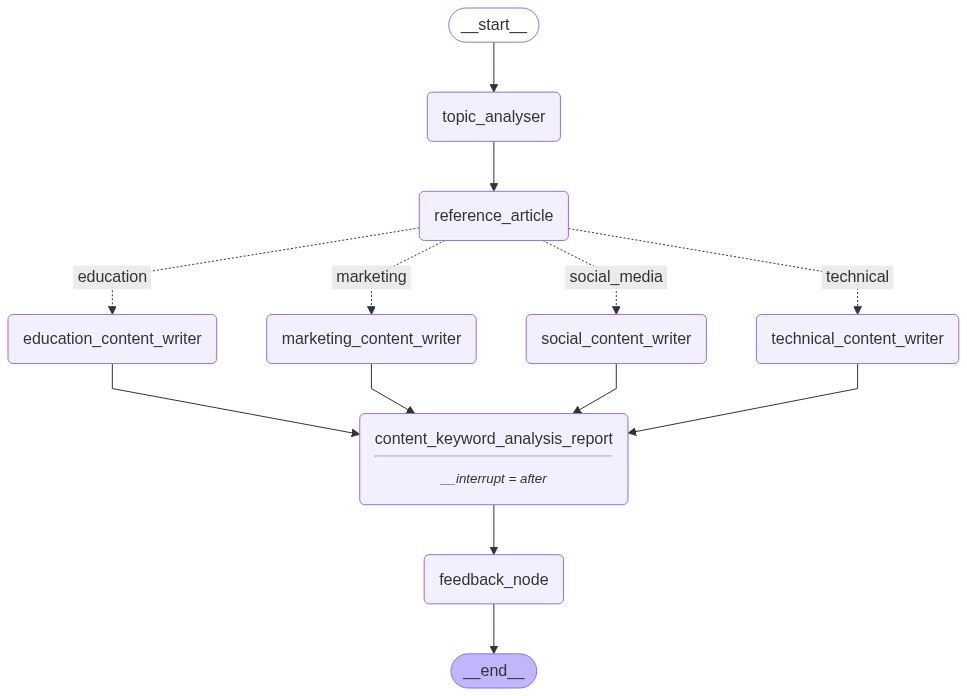

In [12]:
app

In [18]:
app.get_graph().draw_mermaid_png(output_file_path="content_writer_structure.png")

In [13]:

content_output=app.invoke({
    "topic_name": "LLM",
    "goal": "technical",
    "type_audience": "data scientists",
    "word_count":200
})


Analysing the Topic and Google
Referencing with wikepedia
Technical Content Writer


/home/ubuntu/large_model/lib/python3.12/site-packages/langgraph/_internal/_runnable.py:657: UserWarning: WARNING! max_output_tokens is not default parameter.
                max_output_tokens was transferred to model_kwargs.
                Please confirm that max_output_tokens is what you intended.
  input = context.run(step.invoke, input, config, **kwargs)
/home/ubuntu/large_model/lib/python3.12/site-packages/langgraph/_internal/_runnable.py:657: UserWarning: Parameters {'reasoning'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  input = context.run(step.invoke, input, config, **kwargs)


Content Analysis


In [14]:
out

NameError: name 'out' is not defined